# LIBRARIES IMPORT

In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import pandas as pd

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn

# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import TensorDataset

from torch.utils.data import DataLoader
import os

from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F



# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)


# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)


logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline



PyTorch version: 2.8.0+cu126
Device: cuda


# FUNCTIONS

FUNCTION CREATE SEQUENCES

In [ ]:
def create_sequences(X, y, sample_indices, window_size, stride, label_encoder=None):
    """
    Creates sequences from the processed data for each sample index.

    Args:
        X (pd.DataFrame): The processed feature DataFrame.
        y (pd.DataFrame): The labels DataFrame. Can be None or empty for test set.
        sample_indices (np.ndarray): Array of unique sample indices.
        window_size (int): The size of the time window for each sequence.
        stride (int): The step size to move the window.
        label_encoder (LabelEncoder or None): Fitted LabelEncoder for encoding labels.

    Returns:
        tuple: A tuple containing:
            - sequences (np.ndarray): Array of sequences.
            - sequence_labels (np.ndarray or None): Array of encoded integer labels for each sequence, or None if y is None or empty.
            - sequence_sample_indices (list): List of sample indices for each sequence.
    """
    sequences = []
    sequence_labels = []
    sequence_sample_indices = [] # New list to store sample indices for each sequence

    # Check if y is provided and not empty
    y_provided = y is not None and not y.empty
    if y_provided:
        y_indexed = y.set_index('sample_index')


    for sample_index in sample_indices:
        # Get data for the current sample
        sample_data = X[X['sample_index'] == sample_index].drop(columns=['sample_index', 'time']) # Drop 'time' as well

        # Get the label for the current sample if y is provided
        sample_label = None
        if y_provided:
            try:
                # If `y_indexed` contains duplicate `sample_index` entries (due to oversampling)
                # `loc` might return a Series. We need to ensure a single scalar label is extracted.
                temp_label = y_indexed.loc[sample_index, 'label']
                if isinstance(temp_label, pd.Series):
                    # Assuming all labels for a given sample_index are the same after oversampling
                    # if not, this needs a more robust aggregation (e.g., mode)
                    sample_label = temp_label.iloc[0]
                else:
                    sample_label = temp_label
            except KeyError:
                # This should not happen if sample_indices are from X and y covers all of them
                print(f"Warning: sample_index {sample_index} not found in y_indexed.")
                continue # Skip this sample if label is missing


        # Iterate through the sample data to create sequences
        # Adjust the range to ensure the last sequence fits within the data
        if len(sample_data) >= window_size:
            for i in range(0, len(sample_data) - window_size + 1, stride):
                sequence = sample_data.iloc[i : i + window_size]
                sequences.append(sequence.values)

                # Append the label for this sequence (which is the label for the entire sample)
                if y_provided:
                    sequence_labels.append(sample_label)

                # Append the sample index for this sequence
                sequence_sample_indices.append(sample_index) # Store the sample index


        # else:
            # print(f"Warning: sample_index {sample_index} has data length {len(sample_data)} which is less than window_size {window_size}. Skipping.")


    # Convert lists to numpy arrays
    if sequences: # Check if sequences list is not empty
        sequences = np.array(sequences)
    else:
        sequences = np.array([]) # Return empty numpy array if no sequences were created


    # Convert sequence_labels to numpy array and encode if labels were provided
    if y_provided and sequence_labels and label_encoder is not None:
        # Encode the sequence labels
        sequence_labels_encoded = label_encoder.transform(sequence_labels)
        sequence_labels = np.array(sequence_labels_encoded)
    else:
        sequence_labels = None # Set to None if no labels or no encoder


    return sequences, sequence_labels, sequence_sample_indices # Return sequence_sample_indices


FUNCTION RECURRENT SUMMARY

In [ ]:
def recurrent_summary(model, input_size):
    """
    Summary function compatible with:
      - Conv1d
      - Linear
      - LSTM / GRU / RNN
      - BatchNorm / LayerNorm
      - Custom Attention layer (context + attn_weights)
    """

    import torch
    import torch.nn as nn

    output_shapes = {}
    hooks = []

    # -----------------------------
    # 1. Define robust hook
    # -----------------------------
    def get_hook(name):
        def hook(module, input, output):

            # ---- CASE A: Attention(context, weights) ----
            if isinstance(output, tuple) and len(output) == 2:
                context, weights = output

                try:
                    ctx_shape = list(context.shape)
                except:
                    ctx_shape = "N/A"

                try:
                    w_shape = list(weights.shape)
                except:
                    w_shape = "N/A"

                output_shapes[name] = f"context: {ctx_shape}, attn_weights: {w_shape}"
                return

            # ---- CASE B: RNN outputs (rnn_out, hidden) ----
            if isinstance(output, tuple):
                shapes = []
                for o in output:
                    try:
                        shapes.append(list(o.shape))
                    except:
                        shapes.append("N/A")
                output_shapes[name] = str(shapes)
                return

            # ---- CASE C: Standard layer ----
            try:
                shape = list(output.shape)
            except:
                shape = "N/A"

            output_shapes[name] = f"{shape}"

        return hook

    # -----------------------------
    # 2. Register hooks
    # -----------------------------
    for name, module in model.named_modules():

        if isinstance(module, (nn.Conv1d,
                               nn.Linear,
                               nn.GRU,
                               nn.LSTM,
                               nn.RNN,
                               nn.BatchNorm1d,
                               nn.LayerNorm)):
            hooks.append(module.register_forward_hook(get_hook(name)))

        if module.__class__.__name__ == "Attention":
            hooks.append(module.register_forward_hook(get_hook(name)))

    # -----------------------------
    # 3. Forward pass with dummy input
    # -----------------------------
    device = next(model.parameters()).device
    dummy_input = torch.randn(1, *input_size).to(device)

    model.eval()
    with torch.no_grad():
        model(dummy_input)

    # Remove hooks
    for h in hooks:
        h.remove()

    # -----------------------------
    # 4. PRINT SUMMARY
    # -----------------------------
    print("-" * 100)
    print(f"{'Layer (type)':<40} {'Output Shape':<40} {'Params':<10}")
    print("=" * 100)

    total_params = 0

    for name, module in model.named_modules():

        if name in output_shapes:

            params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            total_params += params

            print(f"{name:<40} {output_shapes[name]:<40} {params:<10}")

    print("=" * 100)
    print(f"Total trainable params: {total_params:,}")
    print("-" * 100)


FUNCTION RECURRENT CLASSIFIER

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_out):
        # rnn_out: (batch, seq_len, hidden_dim)
        scores = self.attn(rnn_out).squeeze(-1)         # (batch, seq_len)
        weights = torch.softmax(scores, dim=1)          # (batch, seq_len)
        context = (rnn_out * weights.unsqueeze(-1)).sum(dim=1)
        return context, weights

class RecurrentClassifier(nn.Module):
    """
    Improved RNN classifier:
    Conv1D → LSTM/GRU → Attention → Dense
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
    ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # ---------- 1) CONV1D FEATURE EXTRACTOR ----------
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        rnn_input_dim = 64

        # ---------- 2) RNN BLOCK ----------
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        rnn_module = rnn_map[rnn_type]

        dropout_val = dropout_rate if num_layers > 1 else 0

        self.rnn = rnn_module(
            input_size=rnn_input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        rnn_out_dim = hidden_size * (2 if bidirectional else 1)

        # ---------- 3) ATTENTION ----------
        self.attention = Attention(rnn_out_dim)

        # ---------- 4) CLASSIFIER ----------
        self.fc1 = nn.Linear(rnn_out_dim, 64)
        self.bn = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes)

        # ---------- INIT ----------
        self.reset_parameters()


    def forward(self, x):
        """
        x: (batch, seq_len, input_size)
        """

        # --- CONV BLOCK ---
        x = x.transpose(1, 2)            # → (batch, channels=input_size, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.transpose(1, 2)            # → (batch, seq_len, channels=64)

        # --- RNN BLOCK ---
        rnn_out, hidden = self.rnn(x)

        # If LSTM, take only hidden state h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # --- ATTENTION ---
        context, attn_weights = self.attention(rnn_out)

        # --- CLASSIFIER ---
        x = F.relu(self.fc1(context))
        x = self.bn(x)
        logits = self.fc2(x)

        return logits   # (batch, num_classes)

    def reset_parameters(self):
        # ---- CONV ----
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)

        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)

        # ---- RNN ----
        for name, param in self.rnn.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param)
            elif "bias" in name:
                nn.init.constant_(param, 0.0)

                # Forget gate bias for LSTM
                if self.rnn_type == 'LSTM':
                    hidden = self.hidden_size
                    if "bias_ih" in name:
                        param.data[hidden:2*hidden] = 1.0

        # ---- ATTENTION ----
        nn.init.xavier_uniform_(self.attention.attn.weight)
        nn.init.constant_(self.attention.attn.bias, 0.0)

        # ---- CLASSIFIER ----
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)


FUNCTION TRAIN ONE EPOCH

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, scheduler, device,
                    l1_lambda=0, l2_lambda=0):

    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        # --------- FORWARD (mixed precision) ---------
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # L1 regularization only
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm

        # --------- BACKWARD (with gradient scaling) ---------
        scaler.scale(loss).backward()

        # --------- GRADIENT CLIPPING ---------
        scaler.unscale_(optimizer)  # IMPORTANT: unscale before clipping!
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        # --------- OPTIMIZER STEP ---------
        scaler.step(optimizer)
        scaler.update()

        # --------- SCHEDULER STEP (PER BATCH) ---------
        if scheduler is not None:
            scheduler.step()

        # --------- METRICS ---------
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)

        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # --------- EPOCH METRICS ---------
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1


FUNCTION VALIDATE ONE EPOCH

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:s
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            logits = model(inputs)
            loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)

            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy


FUNCTION LOG METRICS TO TENSORBORD

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

FUNCTION FIT

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping only if patience > 0 AND val_loader is provided
    use_early_stopping = (patience > 0 and val_loader is not None)

    if use_early_stopping:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop
    for epoch in range(1, epochs + 1):

        # Train
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, scheduler, device, l1_lambda, l2_lambda
        )

        # Validation (ONLY if val_loader is provided)
        if val_loader is not None:
            val_loss, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )
        else:
            val_loss, val_f1 = None, None   # <-- Safety defaults

        # Store metrics
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # TensorBoard logging
        if writer is not None:
            log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model)

        # Print logs
        current_lr = optimizer.param_groups[0]["lr"]

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
              if val_loader is not None:

                print(
                    f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f} | F1={val_f1:.4f} | "
                    f"LR={current_lr:.6f}"
                )
              else:
                print(
                    f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                    f"LR={current_lr:.6f}"
                )

        # Early stopping
        if use_early_stopping:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model if early stopping was used
    if restore_best_weights and use_early_stopping:
        model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save FINAL model if no early stopping
    if not use_early_stopping:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    if writer is not None:
        writer.close()

    return model, training_history

FOCAL LOSS

In [ ]:
class FocalLossWithSmoothing(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, smoothing=0.1, reduction='mean'):
        super().__init__()

        # Alpha must be a vector of weights for each classes
        # if None → no weighting
        if alpha is not None:
            alpha = torch.tensor(alpha, dtype=torch.float32)
        self.alpha = alpha

        self.gamma = gamma
        self.smoothing = smoothing
        self.reduction = reduction

    def smooth_labels(self, targets, num_classes):
        with torch.no_grad():
            smoothed = torch.full(
                (targets.size(0), num_classes),
                self.smoothing / (num_classes - 1),
                device=targets.device
            )
            smoothed.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
        return smoothed

    def forward(self, inputs, targets):
        """
        inputs: logits (batch_size, num_classes)
        targets: class indices (batch_size)
        """
        num_classes = inputs.size(1)

        # -- Label smoothing
        targets_smoothed = self.smooth_labels(targets, num_classes)

        # -- Log-softmax
        log_probs = F.log_softmax(inputs, dim=1)
        probs = log_probs.exp()

        # -- Focal factor
        focal_factor = (1 - probs) ** self.gamma

        # -- Apply class weights alpha
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)  # shape (num_classes,)
            alpha = alpha.unsqueeze(0)            # shape (1, num_classes)
            weighted_log_probs = alpha * targets_smoothed * focal_factor * log_probs
        else:
            weighted_log_probs = targets_smoothed * focal_factor * log_probs

        loss = -weighted_log_probs.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


WINDOWING

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# ==========================================
# Analyze Autocorrelation for Multiple Samples
# ==========================================
def analyze_autocorrelation(X, sample_indices, max_lag=100, n_samples=5):
    """
    Analyze autocorrelation to determine optimal window size

    Args:
        X: DataFrame with time series data
        sample_indices: Array of unique sample indices
        max_lag: Maximum lag to check
        n_samples: Number of random samples to analyze
    """
    # Select random samples
    selected_samples = np.random.choice(
        sample_indices,
        min(n_samples, len(sample_indices)),
        replace=False
    )

    # Features to analyze (joint and survey features)
    joint_features = [col for col in X.columns if col.startswith('joint_')]
    survey_features = [col for col in X.columns if col.startswith('pain_survey_')]
    all_features = joint_features + survey_features

    print(f"Analyzing {len(selected_samples)} random samples...")
    print(f"Checking {len(all_features)} features")

    # Plot autocorrelation for each sample
    fig, axes = plt.subplots(n_samples, 2, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    optimal_lags = []

    for idx, sample_idx in enumerate(selected_samples):
        # Get sample data
        sample_data = X[X['sample_index'] == sample_idx].sort_values('time')
        sample_data = sample_data[all_features]

        # Left plot: First feature
        if len(joint_features) > 0:
            feature_name = joint_features[0]
            plot_acf(
                sample_data[feature_name].values,
                lags=min(max_lag, len(sample_data)-1),
                ax=axes[idx, 0],
                alpha=0.05
            )
            axes[idx, 0].set_title(f'Sample {sample_idx} - {feature_name}')
            axes[idx, 0].axhline(y=0.2, color='red', linestyle='--', label='Threshold 0.2')
            axes[idx, 0].axhline(y=-0.2, color='red', linestyle='--')
            axes[idx, 0].legend()

        # Right plot: Average across all features
        avg_series = sample_data.mean(axis=1)
        plot_acf(
            avg_series.values,
            lags=min(max_lag, len(sample_data)-1),
            ax=axes[idx, 1],
            alpha=0.05
        )
        axes[idx, 1].set_title(f'Sample {sample_idx} - Average of all features')
        axes[idx, 1].axhline(y=0.2, color='red', linestyle='--', label='Threshold 0.2')
        axes[idx, 1].axhline(y=-0.2, color='red', linestyle='--')
        axes[idx, 1].legend()

        # Find where autocorrelation drops below 0.2
        acf_values = acf(avg_series.values, nlags=min(max_lag, len(sample_data)-1))
        significant_lags = np.where(np.abs(acf_values) > 0.2)[0]
        if len(significant_lags) > 1:
            optimal_lag = significant_lags[-1]
            optimal_lags.append(optimal_lag)
            print(f"  Sample {sample_idx}: Last significant lag at {optimal_lag}")

    plt.tight_layout()
    plt.show()

    # Recommend window size
    if optimal_lags:
        recommended_window = int(np.median(optimal_lags))
        print(f"\n{'='*60}")
        print(f"📊 AUTOCORRELATION ANALYSIS RESULTS")
        print(f"{'='*60}")
        print(f"Significant lags found: {optimal_lags}")
        print(f"Median: {recommended_window}")
        print(f"Mean: {int(np.mean(optimal_lags))}")
        print(f"Range: {min(optimal_lags)} - {max(optimal_lags)}")
        print(f"\n💡 RECOMMENDED WINDOW_SIZE: {recommended_window}")
        print(f"   (This is where autocorrelation drops below 0.2)")
        print(f"{'='*60}")
        return recommended_window
    else:
        print("\n⚠️  Could not determine optimal window size from autocorrelation")
        return None

In [ ]:
def apply_feature_engineering(df, roll=10):
    df = df.copy()

    joint_features = [c for c in df.columns if c.startswith("joint_")]

    for col in joint_features:
        df[col + "_diff"] = df.groupby("sample_index")[col].diff()
        df[col + "_vel"]  = df[col + "_diff"]
        df[col + "_acc"]  = df.groupby("sample_index")[col].diff().diff()

    for col in joint_features:
        df[col + f"_roll_mean_{roll}"] = (
            df.groupby("sample_index")[col]
              .rolling(roll)
              .mean()
              .reset_index(0, drop=True)
        )
        df[col + f"_roll_std_{roll}"] = (
            df.groupby("sample_index")[col]
              .rolling(roll)
              .std()
              .reset_index(0, drop=True)
        )

    df.fillna(method="bfill", inplace=True)
    df.fillna(method="ffill", inplace=True)

    return df


In [ ]:
def compute_alpha_from_counts(counts):
    inv = 1 / np.array(counts, dtype=np.float32)
    alpha = inv / inv.sum()
    return alpha

# DATA LOADING

In [ ]:
#Load the train set
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

#Load the test set
X_test = pd.read_csv('pirate_pain_test.csv')

display(X_train.head(5))
display(y_train.head(5))
display(X_test.head(5))


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,two,two,two,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,two,two,two,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,two,two,two,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,two,two,two,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,two,two,two,0.805971,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5


# DATA ANALYSIS

In [ ]:
#Print the shape of the DataFrame before dropping missing values
print(f"DataFrame shape before dropping missing values: {X_train.shape}")

# Remove rows with any missing values
X_train.dropna(axis=0, how='any', inplace=True)


# Print the shape of the DataFrame after dropping missing values
print(f"DataFrame shape after dropping missing values: {X_train.shape}")



DataFrame shape before dropping missing values: (105760, 40)
DataFrame shape after dropping missing values: (105760, 40)


CONVERTING THE NUMERICAL FEATURES

In [ ]:
# Display a concise summary of the DataFrame
X_train.info()

# Convert 'joint_n' columns to float32 for train and test set
for i in range(31):
    X_train[f'joint_{i:02d}'] = X_train[f'joint_{i:02d}'].astype(np.float32)

for i in range(31):
    X_test[f'joint_{i:02d}'] = X_test[f'joint_{i:02d}'].astype(np.float32)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

ELIMINATING ZERO VARIANCE COLUMNS

In [ ]:
# 1. Zero-variance columns
zero_var_cols = X_train.loc[:, X_train.nunique() == 1].columns.tolist()

print("Zero-variance columns:", zero_var_cols)

# Remove them
X_train.drop(columns=zero_var_cols, inplace=True)
X_test.drop(columns=zero_var_cols, inplace=True)


Zero-variance columns: ['joint_30']


ELIMINATING HIGH CORRELATED FEATURES

In [ ]:
import numpy as np

# Keep only numerical features
num_cols = X_train.select_dtypes(include=np.number).columns
corr = X_train[num_cols].corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Highly correlated features (threshold = 0.90)
high_corr = [col for col in upper.columns if any(upper[col] > 0.90)]

print("Highly correlated columns:", high_corr)

X_train.drop(columns=high_corr, inplace=True)
X_test.drop(columns=high_corr, inplace=True)


Highly correlated columns: ['joint_11']


CREATE DATAFRAME FOR CROSS VALIDATION






In [ ]:
df = pd.merge(X_train, y_train, on='sample_index')

WINDOW AND STRIDE SELECTION

Analyzing 5 random samples...
Checking 33 features
  Sample 630: Last significant lag at 54
  Sample 271: Last significant lag at 27
  Sample 135: Last significant lag at 2


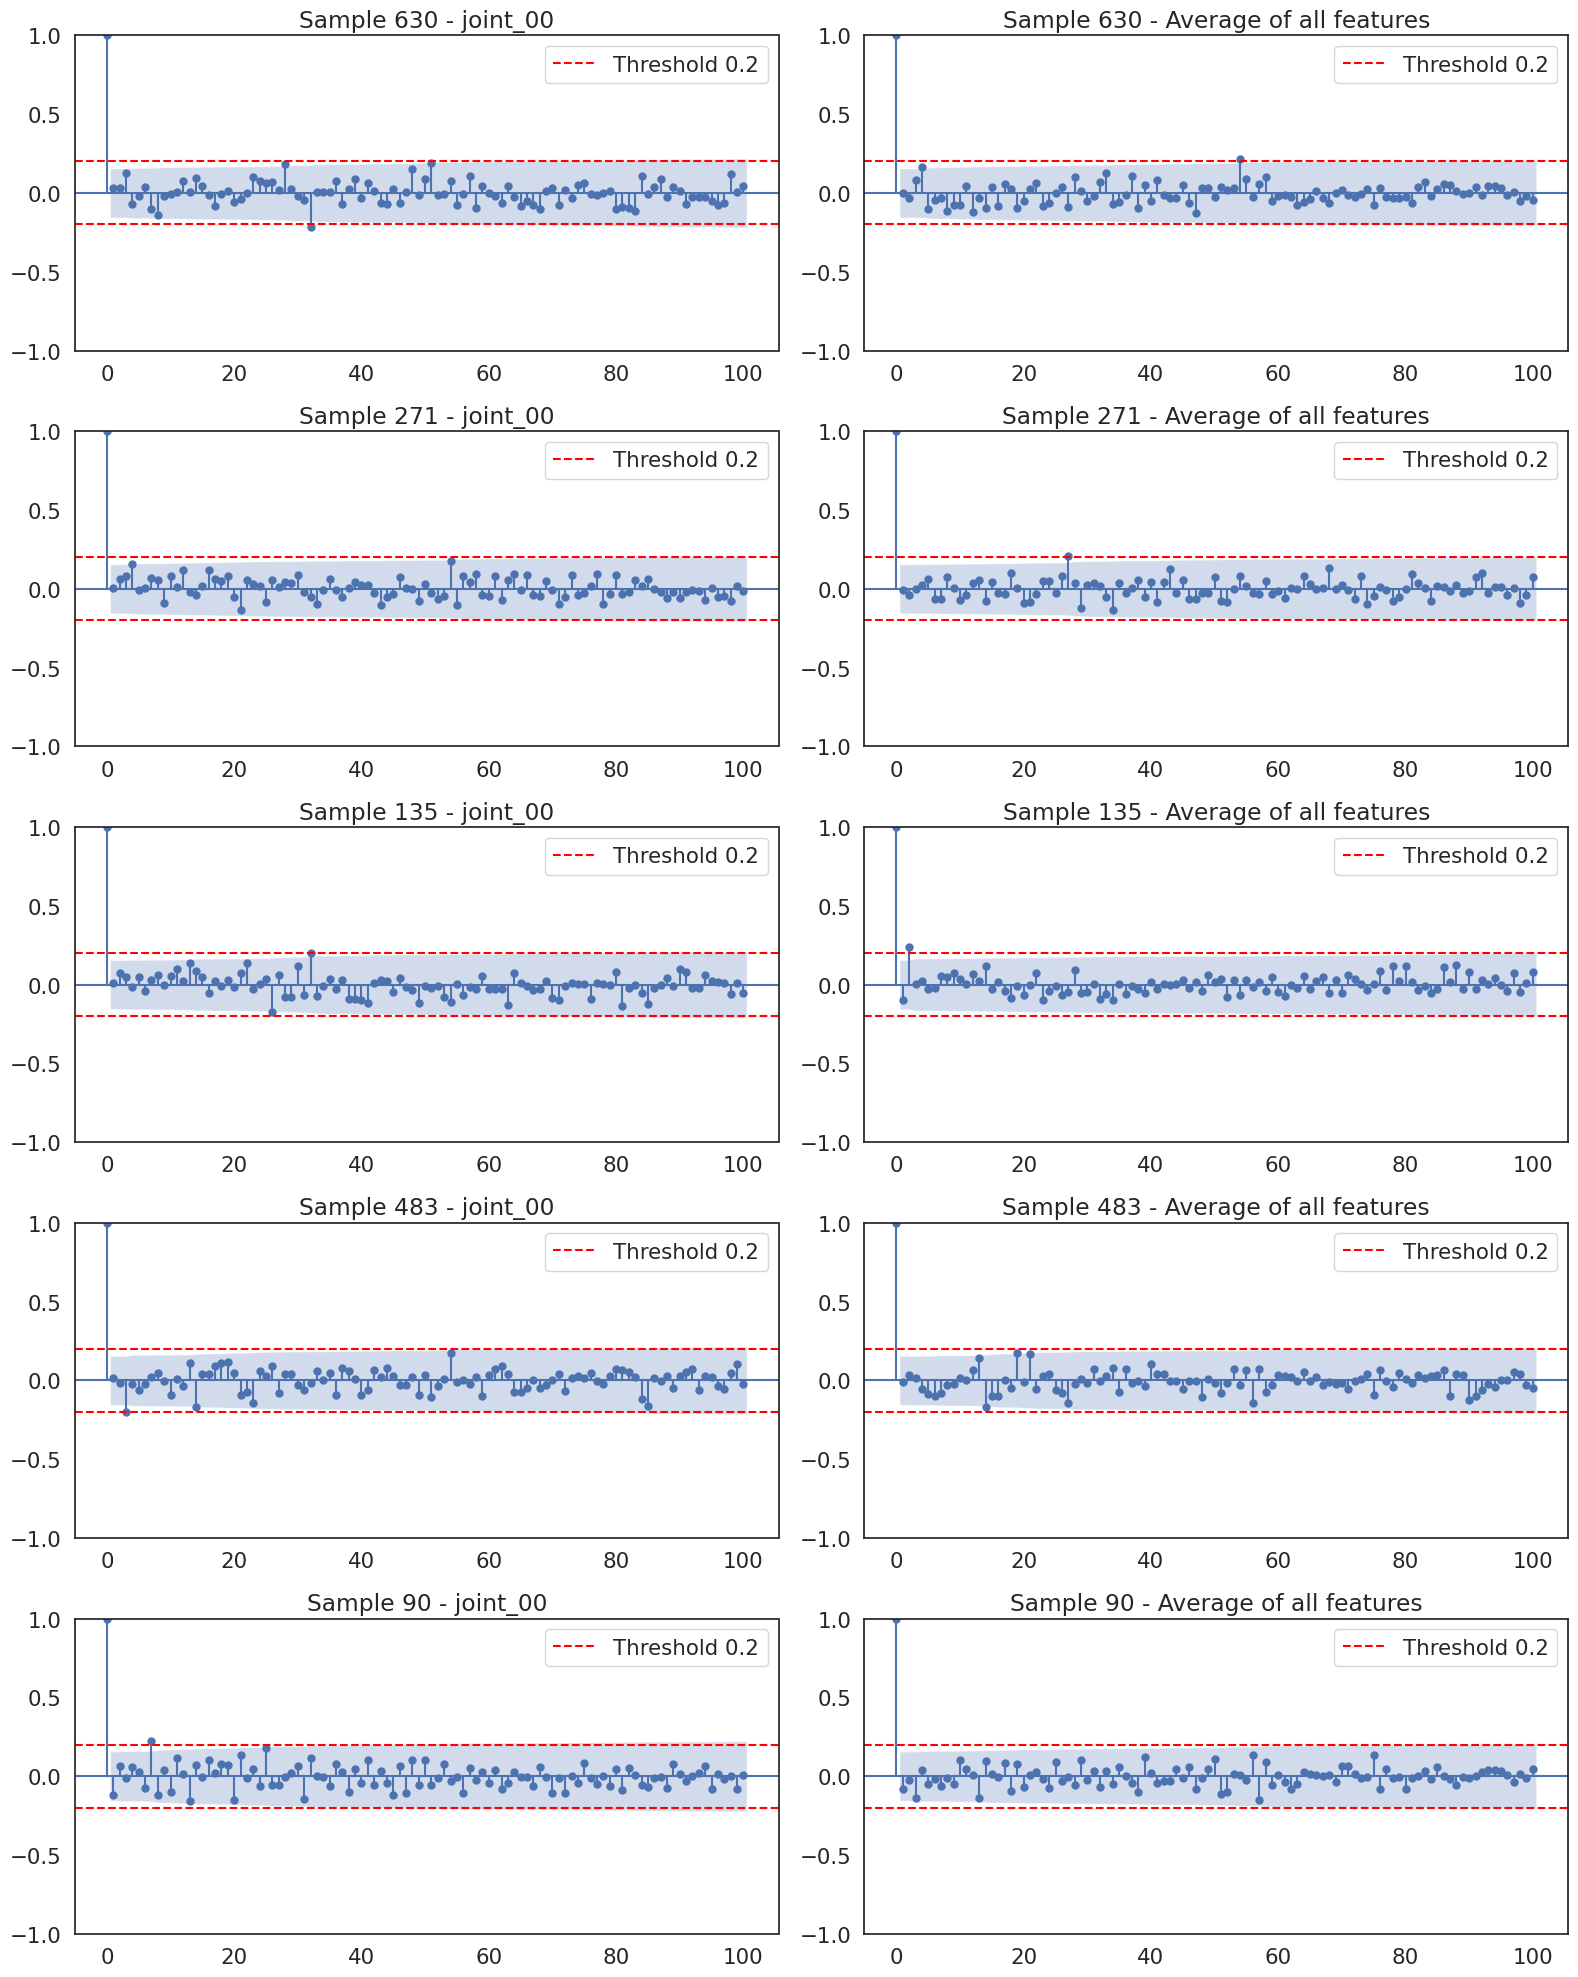


📊 AUTOCORRELATION ANALYSIS RESULTS
Significant lags found: [np.int64(54), np.int64(27), np.int64(2)]
Median: 27
Mean: 27
Range: 2 - 54

💡 RECOMMENDED WINDOW_SIZE: 27
   (This is where autocorrelation drops below 0.2)


In [ ]:
# Run analysis
train_sample_indices = X_train['sample_index'].unique()
recommended_window = analyze_autocorrelation(
    X_train,
    train_sample_indices,
    max_lag=100,
    n_samples=5
)

# DATA PROCESSING

ALPHA FOR FOCAL LOSS

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch

# y_train: DataFrame with at least ['sample_index', 'label']

#One row per sequence
df_seq = y_train[['sample_index', 'label']].drop_duplicates(subset=['sample_index'])

#Fit LabelEncoder on global labels
label_encoder = LabelEncoder()
label_encoder.fit(df_seq['label'])

print("Classes in encoder order:", label_encoder.classes_)

#Count samples per class in LabelEncoder order
counts = []
for c in label_encoder.classes_:
    counts.append((df_seq['label'] == c).sum())

counts = np.array(counts, dtype=np.float32)
print("Counts per class (encoder order):", counts)

alpha_np = compute_alpha_from_counts(counts)

alpha_tensor = torch.tensor(alpha_np, dtype=torch.float32).to(device)
print("Alpha (tensor):", alpha_tensor)

Classes in encoder order: ['high_pain' 'low_pain' 'no_pain']
Counts per class (encoder order): [ 56.  94. 511.]
Alpha (tensor): tensor([0.5864, 0.3493, 0.0643], device='cuda:0')


DATA SPLITTING

In [ ]:
# Assuming 'sample_index' can be used for splitting to keep samples together
# We need to split unique sample_index values first and then filter the dataframes

df_samples = y_train[['sample_index', 'label']].drop_duplicates()


train_samples, val_samples = train_test_split(
    df_samples,
    test_size=0.3,
    random_state=SEED,
    stratify=df_samples['label']
)

train_sample_indices = train_samples['sample_index'].values
val_sample_indices   = val_samples['sample_index'].values

# Filter X_train and y_train based on the split sample indices
X_train_split = X_train[X_train['sample_index'].isin(train_sample_indices)].copy()
y_train_split = y_train[y_train['sample_index'].isin(train_sample_indices)].copy()

X_val_split = X_train[X_train['sample_index'].isin(val_sample_indices)].copy()
y_val_split = y_train[y_train['sample_index'].isin(val_sample_indices)].copy()

print(f"Original training data shape: {X_train.shape}, {y_train.shape}")
print(f"Training split shape: {X_train_split.shape}, {y_train_split.shape}")
print(f"Validation split shape: {X_val_split.shape}, {y_val_split.shape}")

# It's important to verify that the split is done correctly and that sample_index is consistent
print("\nChecking consistency of sample_index in splits:")
print(f"Unique sample_index in X_train_split: {X_train_split['sample_index'].nunique()}")
print(f"Unique sample_index in y_train_split: {y_train_split['sample_index'].nunique()}")
print(f"Unique sample_index in X_val_split: {X_val_split['sample_index'].nunique()}")
print(f"Unique sample_index in y_val_split: {y_val_split['sample_index'].nunique()}")

# Print initial value counts
print(y_train_split["label"].value_counts())

Original training data shape: (105760, 38), (661, 2)
Training split shape: (73920, 38), (462, 2)
Validation split shape: (31840, 38), (199, 2)

Checking consistency of sample_index in splits:
Unique sample_index in X_train_split: 462
Unique sample_index in y_train_split: 462
Unique sample_index in X_val_split: 199
Unique sample_index in y_val_split: 199
label
no_pain      357
low_pain      66
high_pain     39
Name: count, dtype: int64


FEATURE ENGINEERING

In [ ]:
# We apply feature engineering to create more informative predictors
# and improve the model's ability to learn meaningful patterns
X_train_split = apply_feature_engineering(X_train_split)
X_val_split   = apply_feature_engineering(X_val_split)
X_test = apply_feature_engineering(X_test)

DATA ENCODIG

In [ ]:
#Extract the numerical features
numerical_features = X_train_split.select_dtypes(include=np.number).columns.tolist()

#Delete time and sample_index because they aren't features
numerical_features = [col for col in numerical_features if col not in ['sample_index', 'time']]

#Extract the categorical features
categorical_features = X_train_split.select_dtypes(include='object').columns.tolist()

#Define the scaler and the encoder
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create a preprocessing pipeline that includes the column transformer
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the preprocessing pipeline on the training data
preprocessing_pipeline.fit(X_train_split)


# Apply the preprocessing pipeline to the training, validation, and test data
X_train_processed = preprocessing_pipeline.transform(X_train_split)
X_val_processed = preprocessing_pipeline.transform(X_val_split)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Get the feature names after preprocessing
# This is a bit more involved with ColumnTransformer and Pipeline
# You can access the fitted preprocessor and then the transformers
fitted_preprocessor = preprocessing_pipeline.named_steps['preprocessor']
numerical_feature_names = numerical_features
categorical_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine the feature names
processed_feature_names = numerical_feature_names + categorical_feature_names.tolist()

# Convert the processed data back to DataFrames for easier handling (optional but often useful)
X_train_processed = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train_split.index)
X_val_processed = pd.DataFrame(X_val_processed, columns=processed_feature_names, index=X_val_split.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)

# Re-add 'sample_index' and 'time' to the processed dataframes
X_train_processed['sample_index'] = X_train_split['sample_index']
X_train_processed['time'] = X_train_split['time']
X_val_processed['sample_index'] = X_val_split['sample_index']
X_val_processed['time'] = X_val_split['time']
X_test_processed['sample_index'] = X_test['sample_index']
X_test_processed['time'] = X_test['time']


print("Processed training data shape:", X_train_processed.shape)
display(X_train_processed.head())

print("\nProcessed validation data shape:", X_val_processed.shape)
display(X_val_processed.head())

print("\nProcessed test data shape:", X_test_processed.shape)
display(X_test_processed.head())

Processed training data shape: (73920, 186)


,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,...,joint_29_roll_mean_10,joint_29_roll_std_10,n_legs_one+peg_leg,n_legs_two,n_hands_one+hook_hand,n_hands_two,n_eyes_one+eye_patch,n_eyes_two,sample_index,time
0,0.531989,-2.477418,0.521705,-1.014480,0.746416,0.322606,0.791366,0.796182,0.633591,0.747881,...,-0.676373,-0.782269,0.0,1.0,0.0,1.0,0.0,1.0,0,0
1,0.531989,0.512887,0.521705,0.504774,0.956954,0.512042,0.709998,0.937446,0.700828,0.723878,...,-0.676373,-0.782269,0.0,1.0,0.0,1.0,0.0,1.0,0,1
2,0.531989,-2.477418,0.521705,0.504774,0.673804,0.204186,0.761771,0.684407,0.664611,0.742206,...,-0.676373,-0.782269,0.0,1.0,0.0,1.0,0.0,1.0,0,2
3,0.531989,0.512887,0.521705,0.504774,-0.068568,0.830903,0.722486,0.718442,0.520312,0.700154,...,-0.676373,-0.782269,0.0,1.0,0.0,1.0,0.0,1.0,0,3
4,0.531989,0.512887,0.521705,0.504774,0.722905,0.569937,0.758789,0.638942,0.739764,0.769865,...,-0.676373,-0.782269,0.0,1.0,0.0,1.0,0.0,1.0,0,4



Processed validation data shape: (31840, 186)


,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,...,joint_29_roll_mean_10,joint_29_roll_std_10,n_legs_one+peg_leg,n_legs_two,n_hands_one+hook_hand,n_hands_two,n_eyes_one+eye_patch,n_eyes_two,sample_index,time
160,0.531989,-0.982266,0.521705,0.504774,1.468866,0.558026,1.244818,0.642080,0.739601,0.686197,...,0.192716,-0.099872,0.0,1.0,0.0,1.0,0.0,1.0,1,0
161,0.531989,0.512887,0.521705,0.504774,1.724613,0.809086,0.811905,0.522314,0.776618,0.818710,...,0.192716,-0.099872,0.0,1.0,0.0,1.0,0.0,1.0,1,1
162,0.531989,0.512887,0.521705,0.504774,1.044490,0.521659,1.152933,0.775358,0.641283,0.868877,...,0.192716,-0.099872,0.0,1.0,0.0,1.0,0.0,1.0,1,2
163,0.531989,0.512887,-0.973388,-2.533733,1.398594,0.167191,0.955539,0.525111,0.903136,0.787919,...,0.192716,-0.099872,0.0,1.0,0.0,1.0,0.0,1.0,1,3
164,0.531989,0.512887,0.521705,0.504774,0.772383,0.493769,1.086993,0.563504,0.920543,0.837653,...,0.192716,-0.099872,0.0,1.0,0.0,1.0,0.0,1.0,1,4



Processed test data shape: (211840, 186)


,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,...,joint_29_roll_mean_10,joint_29_roll_std_10,n_legs_one+peg_leg,n_legs_two,n_hands_one+hook_hand,n_hands_two,n_eyes_one+eye_patch,n_eyes_two,sample_index,time
0,0.531989,0.512887,0.521705,0.504774,-0.565194,-0.412812,-0.720970,-1.274162,-0.959593,-1.355741,...,-0.565694,-0.49795,0.0,1.0,0.0,1.0,0.0,1.0,0,0
1,0.531989,0.512887,0.521705,0.504774,-0.272356,-0.577071,-0.529636,-1.024211,-1.092612,-1.388008,...,-0.565694,-0.49795,0.0,1.0,0.0,1.0,0.0,1.0,0,1
2,0.531989,0.512887,0.521705,0.504774,0.034152,-0.176609,-0.599861,-1.106997,-0.976777,-1.462346,...,-0.565694,-0.49795,0.0,1.0,0.0,1.0,0.0,1.0,0,2
3,-0.938585,0.512887,0.521705,0.504774,-0.616891,-0.911586,-0.610315,-0.906908,-1.116705,-1.385447,...,-0.565694,-0.49795,0.0,1.0,0.0,1.0,0.0,1.0,0,3
4,0.531989,0.512887,0.521705,-2.533733,-0.755374,-0.602439,-0.747566,-0.871517,-1.038460,-1.568439,...,-0.565694,-0.49795,0.0,1.0,0.0,1.0,0.0,1.0,0,4


LABEL ENCODING

In [ ]:
# Fit LabelEncoder on the unique labels from the original y_train
# This ensures consistent encoding across train and validation sets
label_encoder = LabelEncoder()

label_encoder.fit(y_train_split['label'])

y_train_split['label_encoded'] = label_encoder.transform(y_train_split['label'])
y_val_split['label_encoded']   = label_encoder.transform(y_val_split['label'])


CREATING SEQUENCES AND OVERSAMPLING

In [ ]:
from imblearn.over_sampling import SMOTE

# Define the window size
WINDOW_SIZE = recommended_window

# Define the stride for overlapping windows
STRIDE = WINDOW_SIZE // 4

#Create sequences for the training data
train_sample_indices = X_train_processed['sample_index'].unique()
train_sequences, train_labels, _ = create_sequences(                 #Ignore the returned sample indices for training
    X_train_processed,
    y_train_split,
    train_sample_indices,
    WINDOW_SIZE,
    STRIDE,
    label_encoder # Pass the fitted label encoder
)


print(f"Training sequences shape: {train_sequences.shape}")
if train_labels is not None:
    print(f"Training labels shape: {train_labels.shape}")
else:
    print("No training labels were generated.")


#We decided to use the alpha parameter of the focal loss to balance the classes, rather than applying SMOTE.
'''
# Print label distribution before SMOTE
if train_labels is not None:
    print("\nTrain labels distribution before SMOTE:")
    unique_labels, counts = np.unique(train_labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Label {label}: {count}")

# Apply SMOTE to the training data
if train_sequences.size > 0 and train_labels is not None:
    # Reshape train_sequences from 3D (num_sequences, window_size, num_features) to 2D
    train_sequences_2d = train_sequences.reshape(train_sequences.shape[0], -1)

    # Initialize SMOTE
    smote = SMOTE(random_state=SEED)

    # Apply SMOTE
    train_sequences_resampled_2d, train_labels_resampled = smote.fit_resample(train_sequences_2d, train_labels)

    # Print label distribution after SMOTE
    print("\nTrain labels distribution after SMOTE:")
    unique_labels_res, counts_res = np.unique(train_labels_resampled, return_counts=True)
    for label, count in zip(unique_labels_res, counts_res):
        print(f"Label {label}: {count}")


    # Reshape the resampled sequences back to 3D
    train_sequences_resampled = train_sequences_resampled_2d.reshape(
    train_sequences_resampled_2d.shape[0], WINDOW_SIZE, -1)

    # Round the one-hot encoded categorical features to binary values
    # The categorical features start at index `len(numerical_features)`
    # `numerical_features` is available from previous preprocessing step
    if len(numerical_features) < train_sequences_resampled.shape[-1]: # Check if there are categorical features
          train_sequences_resampled[:, :, len(numerical_features):] = \
              np.round(train_sequences_resampled[:, :, len(numerical_features):])

    # Update train_ds with the resampled data
    train_ds = TensorDataset(torch.from_numpy(train_sequences_resampled).float(), torch.from_numpy(train_labels_resampled).long())

    train_sequences = train_sequences_resampled
    train_labels    = train_labels_resampled
'''


#Create sequences for the validation data
val_sample_indices = X_val_processed['sample_index'].unique()
val_sequences, val_labels, _ = create_sequences(                # Ignore the returned sample indices for validation
    X_val_processed,
    y_val_split,
    val_sample_indices,
    WINDOW_SIZE,
    STRIDE,
    label_encoder # Pass the fitted label encoder
)

print(f"\nValidation sequences shape: {val_sequences.shape}")
if val_labels is not None:
    print(f"Validation labels shape: {val_labels.shape}")
else:
    print("No validation labels were generated.")

#Create sequences for the test data (without labels)
test_sample_indices = X_test_processed['sample_index'].unique()

# Pass an empty DataFrame for y as test set doesn't have labels, and None for label_encoder
test_sequences, test_labels, test_sample_indices_for_sequences = create_sequences( # Capture the returned sample indices
    X_test_processed,
    pd.DataFrame(), # Pass an empty DataFrame for y
    test_sample_indices,
    WINDOW_SIZE,
    STRIDE,
    None # Pass None for label_encoder as there are no labels to encode
)

print(f"\nTest sequences shape: {test_sequences.shape}")
if test_labels is not None: # Check if test_labels is not None before printing shape
    print(f"Test labels shape: {test_labels.shape}")
else:
    print("No test labels were generated (expected for test set).")


# Print the number of test sample indices generated
print(f"Number of test sample indices for sequences: {len(test_sample_indices_for_sequences)}")



Training sequences shape: (10626, 27, 184)
Training labels shape: (10626,)

Validation sequences shape: (4577, 27, 184)
Validation labels shape: (4577,)

Test sequences shape: (30452, 27, 184)
No test labels were generated (expected for test set).
Number of test sample indices for sequences: 30452


DEFINE THE INPUT SHAPE & NUM CLASSES

In [ ]:
# Define the input shape based on the shape of the training sequences
# The input shape for a sequence model is (window_size, num_features)
input_shape = train_sequences.shape[1:]
print(f"Input shape for the model: {input_shape}")


# Define the number of classes based on the unique values in the training labels
# We need to ensure train_labels are in a format that allows counting unique classes (e.g., encoded integers)
# Assuming train_labels now contains encoded integer labels as handled (or to be handled) in create_sequences
if train_labels is not None:
    num_classes = len(np.unique(train_labels))
    print(f"Number of classes: {num_classes}")
else:
    print("Cannot determine number of classes as training labels were not generated.")
    num_classes = None # Set to None or a default value if labels are missing


Input shape for the model: (27, 184)
Number of classes: 3


CONVERTING ARRAY TO DATALOADER

In [ ]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 64

# Determine optimal number of worker processes for data loading
# This is a simple heuristic, more sophisticated methods exist but this is a good starting point
# num_workers = os.cpu_count() # Get the number of CPU cores

# Set num_workers to a reasonable value, e.g., 2 or 4, or based on experimentation
# For Colab T4 GPU, 2 or 4 is often a good starting point.
# Let's start with 2 and can adjust if needed.
NUM_WORKERS = 2


# Convert numpy arrays to PyTorch tensors and create TensorDatasets
# Use the sequences and labels generated by create_sequences function

# Convert training data
train_ds = TensorDataset(torch.from_numpy(train_sequences).float(), torch.from_numpy(train_labels).long())

# Convert validation data
val_ds = TensorDataset(torch.from_numpy(val_sequences).float(), torch.from_numpy(val_labels).long())

# Convert test data (features only, no labels)
test_sequences_tensor = torch.from_numpy(test_sequences).float()

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test sequences tensor shape: {test_sequences_tensor.shape}")


# Create DataLoader for the training set
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True, # Shuffle training data for better training
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False # Pin memory for faster data transfer to GPU
)

# Create DataLoader for the validation set
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

# For the test set, we might create a DataLoader later when making predictions
# or just use the test_sequences_tensor directly depending on the model's input requirements.
# Let's hold off on creating a DataLoader for the test set for now.

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")


# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Training dataset size: 10626
Validation dataset size: 4577
Test sequences tensor shape: torch.Size([30452, 27, 184])
Number of batches in training loader: 167
Number of batches in validation loader: 72
Features batch shape: torch.Size([64, 27, 184])
Labels batch shape: torch.Size([64])


# MODEL TRAINING







PARAMETERS FOR THE MODEL

In [ ]:
# Training configuration
LEARNING_RATE = 1e-4
MAX_LR = 1e-4
EPOCHS = 10
PATIENCE = 2

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.1       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty (Added L2 regularization with a small value)


In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,         #You can put: True, False
    rnn_type='LSTM'             #You can put: 'RNN', 'LSTM', 'GRU'.
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "LSTM_1" # Updated experiment name
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Set up loss function and optimizer
criterion = FocalLossWithSmoothing(alpha=alpha_tensor, gamma=2.0, smoothing=0.1)

# Define optimizer with L2 regularization (weight_decay in AdamW)
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.3,         # warmup = 30% of epochs
    anneal_strategy='cos',
    div_factor=10,         # base_lr = max_lr / 10
    final_div_factor=100   # lr_final = max_lr / 100
)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))


#%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="LSTM_1",   # Name used to save the model and log the experiment
    patience=PATIENCE,
    scheduler=scheduler
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]



----------------------------------------------------------------------------------------------------
Layer (type)                             Output Shape                             Params    
conv1                                    [1, 32, 27]                              17696     
conv2                                    [1, 64, 27]                              6208      
rnn                                      context: [1, 27, 128], attn_weights: N/A 231424    
attention                                context: [1, 128], attn_weights: [1, 27] 129       
attention.attn                           [1, 27, 1]                               129       
fc1                                      [1, 64]                                  8256      
bn                                       [1, 64]                                  128       
fc2                                      [1, 3]                                   195       
Total trainable params: 264,165
------------------------------

# CROSS VALIDATION

In [ ]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_users: Number of users for validation set
        n_test_users: Number of users for test set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    import pickle

    #DataFrame defined during Data Analysis
    df_samples = df[['sample_index', 'label']].drop_duplicates()

    #Define Stratified K Fold Cross Validation
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    for fold, (train_idx, val_idx) in enumerate(skf.split(df_samples['sample_index'], df_samples['label'])):


        train_samples = df_samples.iloc[train_idx]['sample_index'].values
        val_samples   = df_samples.iloc[val_idx]['sample_index'].values

        #We are saving these values for the Confusion Matrix
        # Save val users
        with open(f"models/fold_{fold}_val_users.pkl", "wb") as f:
             pickle.dump(val_samples, f)

        # Save train users
        with open(f"models/fold_{fold}_train_users.pkl", "wb") as f:
             pickle.dump(train_samples, f)


        print("\n" + "="*50)
        print(f"      >>>  FOLD {fold+1}/{k} — Train samples: {len(train_samples)}, Val samples: {len(val_samples)} <<<")
        print(f"    (window={window_size}, stride={stride}, hidden={hidden_size}, bidirectional={bidirectional})\n")
        print("="*50)

        # Split the dataframe based on sample_index
        # df here is X_train_clean merged with y_train_clean. It contains raw features and 'label' (string).
        df_train_raw = df[df['sample_index'].isin(train_samples)].copy()
        df_val_raw   = df[df['sample_index'].isin(val_samples)].copy()



        # Separate features and labels for oversampling and processing
        X_train_features_raw = df_train_raw.drop(columns=['label'])
        y_train_labels_for_oversampling = (
             df_train_raw[['sample_index', 'label']]
             .drop_duplicates(subset=['sample_index'])
        )

        X_val_features_raw = df_val_raw.drop(columns=['label'])
        y_val_labels_for_oversampling = (df_val_raw[['sample_index', 'label']].drop_duplicates(subset=['sample_index']))

        X_train_features_raw = apply_feature_engineering(X_train_features_raw)
        X_val_features_raw   = apply_feature_engineering(X_val_features_raw)


        numerical_features = X_train_features_raw.select_dtypes(include=np.number).columns.tolist()
        numerical_features = [col for col in numerical_features if col not in ['sample_index', 'time']]
        categorical_features = X_train_features_raw.select_dtypes(include='object').columns.tolist()

        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
          transformers=[
          ('num', numerical_transformer, numerical_features),
          ('cat', categorical_transformer, categorical_features)]
        )

        # Create a preprocessing pipeline that includes the column transformer
        preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

        # Fit the preprocessing pipeline on the training data
        preprocessing_pipeline.fit(X_train_features_raw)

        #We are saving these values for the Confusion Matrix
        with open(f"models/fold_{fold}_preprocess.pkl", "wb") as f:
             pickle.dump(preprocessing_pipeline, f)



        X_train_processed = preprocessing_pipeline.transform(X_train_features_raw)
        X_val_processed = preprocessing_pipeline.transform(X_val_features_raw)

        # Get the feature names after preprocessing
        # This is a bit more involved with ColumnTransformer and Pipeline
        # You can access the fitted preprocessor and then the transformers
        fitted_preprocessor = preprocessing_pipeline.named_steps['preprocessor']
        numerical_feature_names = numerical_features
        categorical_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

        #Combine the feature names
        processed_feature_names = numerical_feature_names + categorical_feature_names.tolist()



        # Convert the processed data back to DataFrames for easier handling (optional but often useful)
        X_train_processed = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train_features_raw.index)
        X_val_processed = pd.DataFrame(X_val_processed, columns=processed_feature_names, index=X_val_features_raw.index)


        # Re-add 'sample_index' and 'time' to the processed dataframes
        X_train_processed['sample_index'] = X_train_features_raw['sample_index']
        X_train_processed['time'] = X_train_features_raw['time']
        X_val_processed['sample_index'] = X_val_features_raw['sample_index']
        X_val_processed['time'] = X_val_features_raw['time']

        label_encoder = LabelEncoder()
        label_encoder.fit(y_train_labels_for_oversampling['label'])

        y_train_labels_for_oversampling['label_encoded'] = label_encoder.transform(y_train_labels_for_oversampling['label'])
        y_val_labels_for_oversampling['label_encoded']   = label_encoder.transform(y_val_labels_for_oversampling['label'])

        #We are saving these values for the Confusion Matrix
        with open(f"models/fold_{fold}_label_encoder.pkl", "wb") as f:
             pickle.dump(label_encoder, f)


        # Example usage: Create sequences for the training data
        train_sample_indices = X_train_processed['sample_index'].unique()
        train_sequences, train_labels, _ = create_sequences( # Ignore the returned sample indices for training
             X_train_processed,
             y_train_labels_for_oversampling,
             train_sample_indices,
             window_size,
             stride,
             label_encoder # Pass the fitted label encoder
        )

        #We decided to use the alpha parameter of the focal loss to balance the classes, rather than applying SMOTE.
        '''
        # Apply SMOTE to the training data
        if train_sequences.size > 0 and train_labels is not None:
            # Reshape train_sequences from 3D (num_sequences, window_size, num_features) to 2D
            train_sequences_2d = train_sequences.reshape(train_sequences.shape[0], -1)

            # Initialize SMOTE
            smote = SMOTE(random_state=seed)

            # Apply SMOTE
            train_sequences_resampled_2d, train_labels_resampled = smote.fit_resample(train_sequences_2d, train_labels)

            # Reshape the resampled sequences back to 3D
            train_sequences_resampled = train_sequences_resampled_2d.reshape(
            train_sequences_resampled_2d.shape[0], window_size, -1)

            # Round the one-hot encoded categorical features to binary values
            # The categorical features start at index `len(numerical_features)`
            # `numerical_features` is available from previous preprocessing step
            if len(numerical_features) < train_sequences_resampled.shape[-1]: # Check if there are categorical features
                 train_sequences_resampled[:, :, len(numerical_features):] = \
                      np.round(train_sequences_resampled[:, :, len(numerical_features):])

            # Update train_ds with the resampled data
            train_ds = TensorDataset(torch.from_numpy(train_sequences_resampled).float(), torch.from_numpy(train_labels_resampled).long())

            train_sequences = train_sequences_resampled
            train_labels    = train_labels_resampled
        '''


        # Example usage: Create sequences for the validation data
        val_sample_indices = X_val_processed['sample_index'].unique()
        val_sequences, val_labels, _ = create_sequences( # Ignore the returned sample indices for validation
             X_val_processed,
             y_val_labels_for_oversampling,
             val_sample_indices,
             window_size,
             stride,
             label_encoder # Pass the fitted label encoder
        )

        # Define the input shape based on the shape of the training sequences
        # The input shape for a sequence model is (window_size, num_features)
        input_shape = train_sequences.shape[1:]

        #We are saving these values for the Confusion Matrix
        np.save(f"models/fold_{fold}_input_shape.npy", np.array(input_shape))


        # Define the number of classes based on the unique values in the training labels
        # We need to ensure train_labels are in a format that allows counting unique classes (e.g., encoded integers)
        # Assuming train_labels now contains encoded integer labels as handled (or to be handled) in create_sequences
        if train_labels is not None:
             num_classes = len(np.unique(train_labels))
        else:
             num_classes = None # Set to None or a default value if labels are missing

        #We are saving these values for the Confusion Matrix
        # Save num_classes for the fold
        with open(f"models/fold_{fold}_num_classes.pkl", "wb") as f:
             pickle.dump(num_classes, f)


        # Convert training data
        train_ds = TensorDataset(torch.from_numpy(train_sequences).float(), torch.from_numpy(train_labels).long())

        # Convert validation data
        val_ds = TensorDataset(torch.from_numpy(val_sequences).float(), torch.from_numpy(val_labels).long())


        # Create DataLoader for the training set
        train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=True, # Shuffle training data for better training
            num_workers=NUM_WORKERS,
            pin_memory=True if torch.cuda.is_available() else False # Pin memory for faster data transfer to GPU
        )


        # Create DataLoader for the validation set
        val_loader = DataLoader(
             val_ds,
             batch_size=batch_size,
             shuffle=False, # No need to shuffle validation data
             num_workers=NUM_WORKERS,
             pin_memory=True if torch.cuda.is_available() else False
        )


        # Initialize best model tracking variables
        best_model = None
        best_performance = float('-inf')

        # Initialise model architecture
        model = RecurrentClassifier(
            input_size=input_shape[-1],
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            bidirectional=bidirectional,
            rnn_type=rnn_type
        ).to(device)

        # Store initial weights to reset model for each split
        initial_state = copy.deepcopy(model.state_dict())

        if verbose > 0:
            print(f"  Training sequences shape: {X_train_processed.shape}")
            print(f"  Validation sequences shape: {X_val_processed.shape}")


        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=learning_rate,          # deve venire dai parametri tunati
                steps_per_epoch=len(train_loader),
                epochs=epochs,
                pct_start=0.3,
                anneal_strategy='cos',
                div_factor=10,
                final_div_factor=100
        )


        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(fold),
            scheduler=scheduler
        )

        # Store results for this split
        fold_losses[f"split_{fold}"] = training_history['val_loss']
        fold_metrics[f"split_{fold}"] = training_history['val_f1']
        best_scores[f"split_{fold}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}\u00b1{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:
# Cross-validation
K = 5                # Number of splits (5 and 10 are considered good values)

# Training
EPOCHS = 250         # Maximum epochs (increase to improve performance)
PATIENCE = 30        # Early stopping patience (increase to improve performance)
VERBOSE = 10         # Print frequency

# Optimisation
LEARNING_RATE = 1e-4     # Learning rate
MAX_LR = 1e-4
BATCH_SIZE = 256                       # Batch size
WINDOW_SIZE = recommended_window       # Input window size
STRIDE = recommended_window // 4       # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128       # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = False    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.1     # Dropout probability
L1_LAMBDA = 0          # L1 penalty
L2_LAMBDA = 1e-5       # L2 penalty

#Focal Loss
criterion = FocalLossWithSmoothing(alpha=alpha_tensor, gamma=0.5, smoothing=0.1)

from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [ ]:
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
    df=df,
    epochs=EPOCHS,
    device=device,
    criterion=criterion,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="LSTM_UNIDIRECTIONAL_1",     #Choose a name for the models
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)



      >>>  FOLD 1/5 — Train samples: 528, Val samples: 133 <<<
    (window=27, stride=6, hidden=128, bidirectional=False)

  Training sequences shape: (84480, 186)
  Validation sequences shape: (21280, 186)
Training 250 epochs...
Epoch   1/250 | Train: Loss=0.1891, F1=0.5001 | Val: Loss=0.1557 | F1=0.4364 | LR=0.000010
Epoch  10/250 | Train: Loss=0.1252, F1=0.6190 | Val: Loss=0.1390 | F1=0.6166 | LR=0.000014
Epoch  20/250 | Train: Loss=0.1090, F1=0.7337 | Val: Loss=0.1349 | F1=0.6709 | LR=0.000025
Epoch  30/250 | Train: Loss=0.0985, F1=0.8218 | Val: Loss=0.1287 | F1=0.7449 | LR=0.000041
Epoch  40/250 | Train: Loss=0.0924, F1=0.8846 | Val: Loss=0.1232 | F1=0.8251 | LR=0.000060
Epoch  50/250 | Train: Loss=0.0893, F1=0.9249 | Val: Loss=0.1219 | F1=0.8444 | LR=0.000078
Epoch  60/250 | Train: Loss=0.0871, F1=0.9514 | Val: Loss=0.1156 | F1=0.8538 | LR=0.000091
Epoch  70/250 | Train: Loss=0.0858, F1=0.9685 | Val: Loss=0.1155 | F1=0.8560 | LR=0.000099


# HYPERPARAMETERS TUNING

In [ ]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Grid search per il TUO modello RNN con dataset pirate_pain,
    usando user-based shuffle split + sliding windows + oversampling.
    """

    from itertools import product
    import numpy as np

    # Liste dei parametri da esplorare
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):

        # Crea la configurazione corrente
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\n CONFIGURATION {idx}/{total} — {config_str}")

        # Parametri da passare alla CV
        run_params = {**fixed_params, **current_config}

        # Esegue la cross-validation COMPLETA su time-series
        fold_losses, fold_metrics, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Salva i risultati
        results[config_str] = fold_scores

        # Aggiorna best
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print(f"====> NEW BEST SCORE = {best_score:.4f}")

        if verbose:
            print(f"Average F1 : {fold_scores['mean']:.4f} ± {fold_scores['std']:.4f}")

    return results, best_config, best_score


In [ ]:
# Cross-validation
K = 10                # Number of splits (5 and 10 are considered good values)

# Training
EPOCHS = 500        # Maximum epochs (increase to improve performance)
PATIENCE = 50         # Early stopping patience (increase to improve performance)
VERBOSE = 10            # Print frequency

# Optimisation
LEARNING_RATE = 1e-4     # Learning rate
MAX_LR = 1e-3

BATCH_SIZE = 256                       # Batch size
WINDOW_SIZE = recommended_window       # Input window size
STRIDE = recommended_window // 4       # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = False    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.3     # Dropout probability
L1_LAMBDA = 0          # L1 penalty
L2_LAMBDA = 1e-5       # L2 penalty

#Focal Loss
criterion = FocalLossWithSmoothing(alpha=alpha_tensor, gamma=1.0, smoothing=0.1)

from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [ ]:
# Define parameters to search (adjust these based on what you want to tune)
param_grid = {
    'window_size': [recommended_window],                            # recommended_window
    'stride': [recommended_window//4],       # recommended_window//4, recommended_window//2
    'hidden_size': [128],
    'bidirectional': [True],
    'dropout_rate': [0.3]
}

# Fixed hyperparameters (not being tuned in this search)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS, # This will be used as num_layers
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE, # Keep RNN_TYPE fixed for a single grid search run
}

# Cross-validation settings (using parameters defined earlier)
cv_settings = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'patience': PATIENCE,
    'verbose': 0, # Set verbose to 0 to avoid excessive output during grid search
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_settings
)

# CONFUSION MATRIX

In [ ]:
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix

def plot_confusion_for_fold(
    df,
    best_config,
    FOLD,
    model_root="models",
    batch_size=256,
    num_workers=0,
    device=None
):
    """
    Plot the confusion matrix for the validation set of a given fold,
    using the best_config used to save the model.

    Assumes:
      - models/fold_{FOLD}_val_users.pkl
      - models/fold_{FOLD}_preprocess.pkl
      - models/fold_{FOLD}_input_shape.npy
      - models/fold_{FOLD}_num_classes.pkl
      - models/fold_{FOLD}_label_encoder.pkl
      - models/{config_str}/split_{FOLD}_model.pt
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n--- Confusion matrix for FOLD {FOLD} ---")


    #    Build config_str
    #    Must match how you saved the models during training:
    #    config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

    config_str = "_".join([f"{k}_{v}" for k, v in best_config.items()])
    model_dir = f"{model_root}/{config_str}"
    best_model_path = f"{model_dir}/split_{FOLD}_model.pt"

    print(f"Using config_str: {config_str}")
    print(f"Model path: {best_model_path}")


    #Load fold-specific artifacts

    val_users = pickle.load(open(f"{model_root}/fold_{FOLD}_val_users.pkl", "rb"))
    preprocessing_pipeline = pickle.load(open(f"{model_root}/fold_{FOLD}_preprocess.pkl", "rb"))
    input_shape = np.load(f"{model_root}/fold_{FOLD}_input_shape.npy")
    num_classes = pickle.load(open(f"{model_root}/fold_{FOLD}_num_classes.pkl", "rb"))
    label_encoder = pickle.load(open(f"{model_root}/fold_{FOLD}_label_encoder.pkl", "rb"))
    class_names = label_encoder.classes_


    #Rebuild raw validation data

    df_val_raw = df[df["sample_index"].isin(val_users)].copy()
    X_val_raw = df_val_raw.drop(columns=['label'])

    # Feature engineering
    X_val_raw = apply_feature_engineering(X_val_raw)

    # Apply preprocessing
    X_val_proc = preprocessing_pipeline.transform(X_val_raw)

    # Rebuild processed DataFrame
    fitted_preprocessor = preprocessing_pipeline.named_steps["preprocessor"]
    numerical_features = fitted_preprocessor.transformers_[0][2]
    categorical_features = fitted_preprocessor.transformers_[1][2]

    categorical_feature_names = (
        fitted_preprocessor.named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )

    processed_feature_names = numerical_features + categorical_feature_names.tolist()

    X_val_proc = pd.DataFrame(
        X_val_proc,
        columns=processed_feature_names,
        index=X_val_raw.index
    )

    # Add back sample_index and time
    X_val_proc["sample_index"] = X_val_raw["sample_index"]
    X_val_proc["time"] = X_val_raw["time"]

    # Labels at sequence level
    y_val_labels = (
        df_val_raw[["sample_index", "label"]]
        .drop_duplicates(subset=["sample_index"])
        .copy()
    )
    y_val_labels["label_encoded"] = label_encoder.transform(y_val_labels["label"])


    #Create sequences for this fold

    val_sample_indices = X_val_proc["sample_index"].unique()

    val_sequences, val_labels, _ = create_sequences(
        X_val_proc,
        y_val_labels,
        val_sample_indices,
        best_config["window_size"],
        best_config["stride"],
        label_encoder
    )

    val_ds = TensorDataset(
        torch.from_numpy(val_sequences).float(),
        torch.from_numpy(val_labels).long()
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )


    # Recreate the model and load weights

    model = RecurrentClassifier(
        input_size=input_shape[-1],
        hidden_size=best_config["hidden_size"],
        num_layers=HIDDEN_LAYERS,
        num_classes=num_classes,
        dropout_rate=best_config["dropout_rate"],
        bidirectional=best_config["bidirectional"],
        rnn_type=RNN_TYPE
    ).to(device)

    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    print("Model loaded and set to eval mode.")


    #Collect predictions on validation set

    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(inputs)

            preds = outputs.argmax(dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())


    #Plot confusion matrix

    cm = confusion_matrix(all_val_labels, all_val_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix – Fold {FOLD} – {config_str}')
    plt.show()

    return cm


In [ ]:
best_fold = 2  # The Fold with the best performance

cm = plot_confusion_for_fold(
    df=df,
    best_config=best_config,
    FOLD=best_fold,
    model_root="models",
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    device=device
)

# FULL-TRAINING SINGLE MODEL

In [ ]:
# Best parameters from grid search
best_dropout_rate = best_config['dropout_rate']
best_hidden_size = best_config['hidden_size']
best_bidirectional = best_config['bidirectional']
best_window_size = best_config['window_size']
best_stride = best_config['stride']

# Make copies of the full training data
X_train_final = X_train.copy()
y_train_final = y_train.copy()

# Apply feature engineering to train and test sets
X_train_final = apply_feature_engineering(X_train_final)
X_test = apply_feature_engineering(X_test)

# Extract numerical features
numerical_features = X_train_final.select_dtypes(include=np.number).columns.tolist()

# Remove 'time' and 'sample_index' because they are not input features
numerical_features = [col for col in numerical_features if col not in ['sample_index', 'time']]

# Extract categorical features
categorical_features = X_train_final.select_dtypes(include='object').columns.tolist()

# Define normalization for numerical features and one-hot encoding for categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column transformer to apply different transformations to different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Wrap the preprocessor in a Pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the preprocessing pipeline on the full training data
preprocessing_pipeline.fit(X_train_final)

# Apply the preprocessing pipeline to training and test sets
X_train_processed = preprocessing_pipeline.transform(X_train_final)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Recover the feature names after preprocessing
fitted_preprocessor = preprocessing_pipeline.named_steps['preprocessor']
numerical_feature_names = numerical_features
categorical_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine numerical and categorical feature names
processed_feature_names = numerical_feature_names + categorical_feature_names.tolist()

# Convert the processed arrays back to DataFrames
X_train_processed = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train_final.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)

# Add back 'sample_index' and 'time' to the processed DataFrames
X_train_processed['sample_index'] = X_train_final['sample_index']
X_train_processed['time'] = X_train_final['time']
X_test_processed['sample_index'] = X_test['sample_index']
X_test_processed['time'] = X_test['time']

# Fit LabelEncoder on the full training labels
# This ensures consistent encoding across train and test predictions
label_encoder = LabelEncoder()
label_encoder.fit(y_train_final['label'])
y_train_final['label_encoded'] = label_encoder.transform(y_train_final['label'])

# Create sequences for the training data
train_sample_indices = X_train_processed['sample_index'].unique()
train_sequences, train_labels, _ = create_sequences(
    X_train_processed,
    y_train_final,
    train_sample_indices,
    best_window_size,
    best_stride,
    label_encoder  # use fitted label encoder
)

#We decided to use the alpha parameter of the focal loss to balance the classes, rather than applying SMOTE.
'''
# ---- Apply SMOTE to the training data (oversampling on sequences) ----
if train_sequences.size > 0 and train_labels is not None:
    # Flatten sequences from 3D (num_sequences, window_size, num_features) to 2D
    train_sequences_2d = train_sequences.reshape(train_sequences.shape[0], -1)

    smote = SMOTE(random_state=SEED)

    # Apply SMOTE in the flattened space
    train_sequences_resampled_2d, train_labels_resampled = smote.fit_resample(
        train_sequences_2d, train_labels
    )

    # Reshape back to 3D
    train_sequences_resampled = train_sequences_resampled_2d.reshape(
        train_sequences_resampled_2d.shape[0], best_window_size, -1
    )

    # Round one-hot encoded categorical features back to {0,1}
    if len(numerical_features) < train_sequences_resampled.shape[-1]:
        train_sequences_resampled[:, :, len(numerical_features):] = \
            np.round(train_sequences_resampled[:, :, len(numerical_features):])

    print(f"\nTraining sequences shape after SMOTE: {train_sequences_resampled.shape}")
    print(f"Training labels shape after SMOTE: {train_labels_resampled.shape}")

    # Update dataset and variables with resampled data
    train_ds = TensorDataset(
        torch.from_numpy(train_sequences_resampled).float(),
        torch.from_numpy(train_labels_resampled).long()
    )

    train_sequences = train_sequences_resampled
    train_labels = train_labels_resampled

else:
    print("SMOTE not applied: no training sequences or labels available.")
'''

# ---- Create sequences for the test data (no labels) ----
test_sample_indices = X_test_processed['sample_index'].unique()

test_sequences, test_labels, test_sample_indices_for_sequences = create_sequences(
    X_test_processed,
    pd.DataFrame(),       # empty DataFrame because test has no labels
    test_sample_indices,
    best_window_size,
    best_stride,
    None  # no label encoder needed for test
)

# Define input shape and number of classes
input_shape = train_sequences.shape[1:]
num_classes = len(np.unique(train_labels))

# Build TensorDatasets
train_ds = TensorDataset(
    torch.from_numpy(train_sequences).float(),
    torch.from_numpy(train_labels).long()
)

test_sequences_tensor = torch.from_numpy(test_sequences).float()

# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_ds = TensorDataset(test_sequences_tensor)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ---- Define final model using best hyperparameters ----
final_model_params = {
    'input_size': input_shape[-1],
    'hidden_size': best_hidden_size,
    'num_layers': HIDDEN_LAYERS,
    'num_classes': num_classes,
    'dropout_rate': best_dropout_rate,
    'rnn_type': RNN_TYPE,
    'bidirectional': best_bidirectional
}

final_model = RecurrentClassifier(**final_model_params).to(device)

optimizer = torch.optim.AdamW(
    final_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=L2_LAMBDA
)

criterion = FocalLossWithSmoothing(alpha=alpha_tensor, gamma=1.0, smoothing=0.1)
scaler = torch.amp.GradScaler()

# OneCycleLR scheduler for the final training
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100
)

# Train the final model on the full training data (no validation set)
history = fit(
    model=final_model,
    train_loader=train_loader,
    val_loader=None,             # no validation
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=VERBOSE,
    l1_lambda=L1_LAMBDA,
    restore_best_weights=False,  # no best_weights because there is no validation
    scheduler=scheduler
)

# ---- Inference on the test set ----
final_model.eval()
all_preds = []

with torch.no_grad():
    for xb in test_loader:
        xb = xb[0].to(device)
        logits = final_model(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Build a DataFrame at sequence level
df_submission = pd.DataFrame({
    "sample_index": test_sample_indices_for_sequences,
    "label": [label_encoder.inverse_transform([p])[0] for p in all_preds]
})

# Aggregate predictions per sample_index using the mode (most frequent label)
final_submission = df_submission.groupby("sample_index")["label"].agg(
    lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
).reset_index()

# Save the submission file
final_submission.to_csv("FINAL_SUBMISSION_5.csv", index=False)
print("Saved FINAL_SUBMISSION_5.csv")


# FINAL MODEL: ENSEMBLE OF CROSS-VALIDATION MODELS

In [ ]:
#Best hyperparameters from grid search

best_dropout_rate = best_config['dropout_rate']
best_hidden_size = best_config['hidden_size']
best_bidirectional = best_config['bidirectional']
best_window_size = best_config['window_size']
best_stride = best_config['stride']


# Copy original train data and apply feature engineering

X_train_final = X_train.copy()
y_train_final = y_train.copy()

X_train_final = apply_feature_engineering(X_train_final)
X_test = apply_feature_engineering(X_test)


# Build preprocessing pipeline (fit on train, apply to train & test)

# Numerical features
numerical_features = X_train_final.select_dtypes(include=np.number).columns.tolist()
# Remove indices/time from the feature set
numerical_features = [col for col in numerical_features if col not in ['sample_index', 'time']]

# Categorical features
categorical_features = X_train_final.select_dtypes(include='object').columns.tolist()

# Define transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Wrap in a Pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit on training data
preprocessing_pipeline.fit(X_train_final)

# Transform train and test
X_test_processed = preprocessing_pipeline.transform(X_test)

# Recover feature names after preprocessing
fitted_preprocessor = preprocessing_pipeline.named_steps['preprocessor']
numerical_feature_names = numerical_features
categorical_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

processed_feature_names = numerical_feature_names + categorical_feature_names.tolist()


X_test_processed = pd.DataFrame(
    X_test_processed,
    columns=processed_feature_names,
    index=X_test.index
)

# Add back 'sample_index' and 'time'
X_test_processed['sample_index'] = X_test['sample_index']
X_test_processed['time'] = X_test['time']


# Label encoding (fit on full training labels)

label_encoder = LabelEncoder()
label_encoder.fit(y_train_final['label'])
y_train_final['label_encoded'] = label_encoder.transform(y_train_final['label'])


#Create test sequences (no labels)

test_sample_indices = X_test_processed['sample_index'].unique()

test_sequences, test_labels, test_sample_indices_for_sequences = create_sequences(
    X_test_processed,
    pd.DataFrame(),       # empty y because test has no labels
    test_sample_indices,
    best_window_size,
    best_stride,
    None                  # no label encoder needed for test
)

# Input size = number of features per time step
input_size = len(processed_feature_names)
num_classes = len(label_encoder.classes_)

# Tensor for test sequences
test_sequences_tensor = torch.from_numpy(test_sequences).float()


#Ensemble of 5 models (soft voting)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Build config string exactly as in training
model_root = "models"
config_str = "_".join([f"{key}_{val}" for key, val in best_config.items()])
model_dir = f"{model_root}/{config_str}"

print("Using config directory:", model_dir)

models = []
for k in range(5):        # assuming 5 folds / 5 saved models
    model_path = f"{model_dir}/split_{k}_model.pt"

    model = RecurrentClassifier(
        input_size=input_size,
        hidden_size=best_hidden_size,
        num_layers=HIDDEN_LAYERS,
        num_classes=num_classes,
        dropout_rate=best_dropout_rate,
        bidirectional=best_bidirectional,
        rnn_type=RNN_TYPE
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    models.append(model)

print("Loaded", len(models), "models into the ensemble.")

# ---- Per-model predictions on the test set ----
all_probs = []

with torch.no_grad():
    test_tensor = test_sequences_tensor.to(device)

    for model in models:
        logits = model(test_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)

# all_probs shape: (n_models, n_sequences, n_classes)
all_probs = np.array(all_probs)

# ---- Soft voting: average probabilities across models ----
avg_probs = np.mean(all_probs, axis=0)           # shape: (n_sequences, n_classes)
pred_indices = np.argmax(avg_probs, axis=1)      # predicted class index per sequence
pred_labels = label_encoder.inverse_transform(pred_indices)


#Build submission at sequence level, then aggregate per sample_index

df_preds = pd.DataFrame({
    "sample_index": test_sample_indices_for_sequences,
    "label": pred_labels
})

# Aggregate by sample_index using the mode (most frequent predicted label)
final_preds = df_preds.groupby("sample_index")["label"].agg(
    lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
).reset_index()

# Save submission file
final_preds.to_csv("ENSEMBLE_6_MODELS_SOFT_VOTE.csv", index=False)
print("Saved ENSEMBLE_6_MODELS_SOFT_VOTE.csv")


# WEIGHTED ENSEMBLE OF DIFFERENT MODELS

In [ ]:
import numpy as np
import pandas as pd
from functools import reduce


#INPUT: only edit these two lists

# List of prediction files (each must have: sample_index, label)
files = [
    # "path/to/predictions_model_1.csv",
    # "path/to/predictions_model_2.csv",
    # "path/to/predictions_model_3.csv",
    # ...
]

# F1 scores (or any quality metric) for the models, same order as 'files'
f1_scores = np.array([
    # 0.95,  # model 1
    # 0.96,  # model 2
    # 0.94,  # model 3
    # ...
])

# Number of models to use (e.g., first N models)
N_MODELS = len(files)      # or set to a smaller number, e.g. 3

files = files[:N_MODELS]
f1_scores = f1_scores[:N_MODELS]

# Optional: normalize weights (does not change argmax)
weights = f1_scores / f1_scores.sum()
print("Using weights:", weights)


#Load and merge predictions
dfs = []
for i, path in enumerate(files, start=1):
    df = pd.read_csv(path)
    df = df.rename(columns={"label": f"label_{i}"})
    dfs.append(df)

# Merge all dataframes on 'sample_index'
df_merged = reduce(lambda left, right: pd.merge(left, right, on="sample_index"), dfs)

#Weighted voting row by row
def weighted_vote(row):
    scores = {}  # label -> sum of weights
    for i, w in enumerate(weights, start=1):
        lab = row[f"label_{i}"]
        scores[lab] = scores.get(lab, 0) + w
    # return label with maximum total weight
    return max(scores.items(), key=lambda x: x[1])[0]

df_merged["label"] = df_merged.apply(weighted_vote, axis=1)


#Build final submission
final_submission = df_merged[["sample_index", "label"]]
final_submission.to_csv("submission_weighted_vote_generic.csv", index=False)
print("Saved submission_weighted_vote_generic.csv")
